# Loading the dataset

In [1]:
%matplotlib inline 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
raw_data = pd.read_csv('network_backup_dataset.csv')
# print(raw_data)
# print(raw_data.loc[0])
# print(raw_data.loc[1])

# Preprocess raw_data to data (numerical representation)
weekdays = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
data = np.zeros(raw_data.shape)
for i in range(raw_data.shape[0]):
    for j in range(raw_data.shape[1]):
        if j == 1: # Day of week
            data[i][j] = float(weekdays[raw_data.loc[i]['Day of Week']])
        elif j == 3: # workflow id
            data[i][j] = float(raw_data.loc[i]['Work-Flow-ID'].split('_')[-1])
        elif j == 4: # file name id
            data[i][j] = float(raw_data.loc[i]['File Name'].split('_')[-1])
        else:
            data[i][j] = float(raw_data.loc[i][j])

# print(data)

a) For a twenty-day period (X-axis unit is day number) plot the backup sizes for
all workflows (color coded on the Y-axis)

In [46]:
# raw_data.loc[(raw_data['Week #'] == 1) & (raw_data['Day of Week'] == 'Monday')]
# np.sum(data[(data[:,0] == 1) & (data[:,1] == 1) & (data[:,3] == 0)], axis=0)[5]

3.8777910233947495

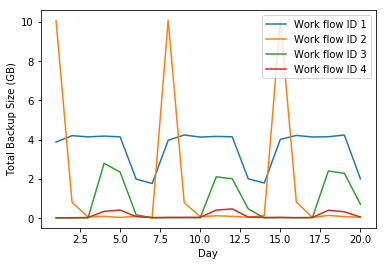

In [55]:
days = np.arange(1,21) # 20 day period
for wid in range(4): # 5 workflows
    sizes = []
    for d in days:
        week, week_day = ((int(d / 7) + 1, int(d % 7)) if int(d % 7) is not 0 else (int(d / 7), 7))
#         print(week, week_day)
        total_size = np.sum(data[(data[:,0] == week) & (data[:,1] == week_day) & (data[:,3] == wid)], axis=0)[5]
        sizes.append(total_size)
    plt.plot(days, sizes, label='Work flow ID %i' % (wid + 1))
    plt.xlabel('Day')
    plt.ylabel('Total Backup Size (GB)')
    plt.legend()

plt.show()

b) Do the same plot for the first 105-day period. Can you identify any repeating patterns?

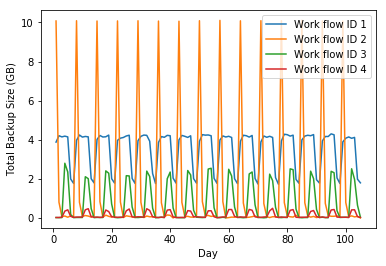

In [56]:
days = np.arange(1,106) # 20 day period
for wid in range(4): # 5 workflows
    sizes = []
    for d in days:
        week, week_day = ((int(d / 7) + 1, int(d % 7)) if int(d % 7) is not 0 else (int(d / 7), 7))
#         print(week, week_day)
        total_size = np.sum(data[(data[:,0] == week) & (data[:,1] == week_day) & (data[:,3] == wid)], axis=0)[5]
        sizes.append(total_size)
    plt.plot(days, sizes, label='Work flow ID %i' % (wid + 1))
    plt.xlabel('Day')
    plt.ylabel('Total Backup Size (GB)')
    plt.legend()

plt.show()
#5 categorical features: Day of the week, hour of the day, work-flow number, file-name, and week number

All the work flows have a very clear pattern of a spike in total backup size every week. For example, the work flow 2 consistently reaches a total backup size of 10G

# Prediction of backup size
## a) Linear Regression

i) Use raw numerical encodings - Here, Monday through Sunday were mapped to 1 through 7, and the work-flow number and file-name were converted to its respective indices, i.e. the strings "work_flow_" and "File_" were removed. The results of fitting a linear model onto this dataset was as such:

Fold 1: train RMSE = 0.103, test RMSE = 0.107
Fold 2: train RMSE = 0.104, test RMSE = 0.100
Fold 3: train RMSE = 0.103, test RMSE = 0.107
Fold 4: train RMSE = 0.104, test RMSE = 0.100
Fold 5: train RMSE = 0.103, test RMSE = 0.107
Fold 6: train RMSE = 0.104, test RMSE = 0.100
Fold 7: train RMSE = 0.103, test RMSE = 0.107
Fold 8: train RMSE = 0.104, test RMSE = 0.100
Fold 9: train RMSE = 0.103, test RMSE = 0.107
Fold 10: train RMSE = 0.104, test RMSE = 0.100


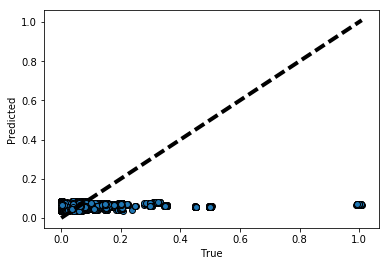

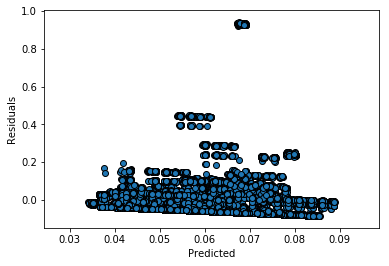

In [49]:
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from math import sqrt

X = data[:,0:5]
y = data[:,5]

kf = KFold(10)
k = 1
lr = linear_model.LinearRegression()
for train_index, test_index in kf.split(X): # Output 10 train test RMSE values
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr.fit(X_train, y_train)
    pred_train, pred_test = lr.predict(X_train), lr.predict(X_test)
    
    rmse_train, rmse_test = sqrt(mean_squared_error(y_train, pred_train)), sqrt(mean_squared_error(y_test, pred_test))
    print("Fold %i: train RMSE = %.3f, test RMSE = %.3f" % (k, rmse_train, rmse_test))
    k += 1

lr = linear_model.LinearRegression()
predicted = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
plt.show()

fig, ax = plt.subplots()
residuals = y - predicted
ax.scatter(predicted, residuals, edgecolors=(0, 0, 0))
ax.set_xlabel('Predicted')
ax.set_ylabel('Residuals')
plt.show()



The figure shows the naive model performs poorly for true backup sizes larger than 0.1 i.e. the model does not generalize well to the full range of backup sizes. However, from observing the second residual vs. predicted graph, the model can fit well for the true backup sizes less than 0.1, which constitutes most of the examples in the dataset. It is clear that the residuals for most examples are in between 0 and 0.2.

ii) Here, we standardize numerical features to have zero mean and unit variance. The results are as such:

Fold 1: train RMSE = 0.103, test RMSE = 0.107
Fold 2: train RMSE = 0.104, test RMSE = 0.100
Fold 3: train RMSE = 0.103, test RMSE = 0.107
Fold 4: train RMSE = 0.104, test RMSE = 0.100
Fold 5: train RMSE = 0.103, test RMSE = 0.107
Fold 6: train RMSE = 0.104, test RMSE = 0.100
Fold 7: train RMSE = 0.103, test RMSE = 0.107
Fold 8: train RMSE = 0.104, test RMSE = 0.100
Fold 9: train RMSE = 0.103, test RMSE = 0.107
Fold 10: train RMSE = 0.104, test RMSE = 0.100


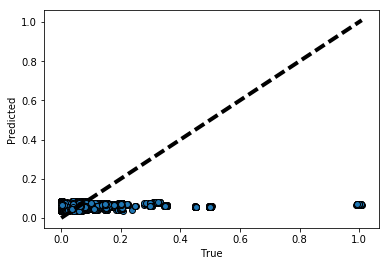

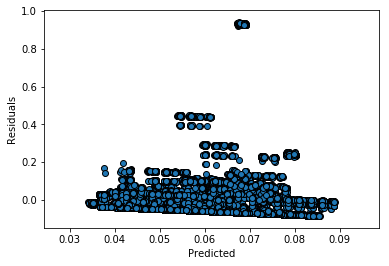

In [50]:
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import StandardScaler

X = data[:,0:5]
y = data[:,5]
scaler = StandardScaler()
X = scaler.fit_transform(X, y)


kf = KFold(10)
k = 1
lr = linear_model.LinearRegression()
for train_index, test_index in kf.split(X): # Output 10 train test RMSE values
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr.fit(X_train, y_train)
    pred_train, pred_test = lr.predict(X_train), lr.predict(X_test)
    
    rmse_train, rmse_test = sqrt(mean_squared_error(y_train, pred_train)), sqrt(mean_squared_error(y_test, pred_test))
    print("Fold %i: train RMSE = %.3f, test RMSE = %.3f" % (k, rmse_train, rmse_test))
    k += 1

lr = linear_model.LinearRegression()
predicted = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
plt.show()

fig, ax = plt.subplots()
residuals = y - predicted
ax.scatter(predicted, residuals, edgecolors=(0, 0, 0))
ax.set_xlabel('Predicted')
ax.set_ylabel('Residuals')
plt.show()



The standardization of features does not affect the regression performance as one can see from the graphs above (they stay highly similar to the those of (i)). Overall, the fitting result does not change.

iii) We will now determine the three most important features that influence the backup size, using f regression and mutual information regression measure.

In [55]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
skb_f = SelectKBest(f_regression, k=3)
X_new_f = skb_f.fit_transform(X, y)
print(skb_f.get_support())
skb_m = SelectKBest(mutual_info_regression, k=3)
X_new_m = skb_m.fit_transform(X, y)
print(skb_m.get_support())

[False  True  True  True False]
[False False  True  True  True]


Hence, the three most important features determined using f_regression are day of week, hour of day, and the work flow id. Conversely, the three most important features determined using mutual info regression are hour of day, work flow id, and the file id. Now we will use only these three features for each regression technique to compare the model performance.

Fold 1: train RMSE = 0.103, test RMSE = 0.107
Fold 2: train RMSE = 0.104, test RMSE = 0.100
Fold 3: train RMSE = 0.103, test RMSE = 0.107
Fold 4: train RMSE = 0.104, test RMSE = 0.100
Fold 5: train RMSE = 0.103, test RMSE = 0.107
Fold 6: train RMSE = 0.104, test RMSE = 0.100
Fold 7: train RMSE = 0.103, test RMSE = 0.107
Fold 8: train RMSE = 0.104, test RMSE = 0.100
Fold 9: train RMSE = 0.103, test RMSE = 0.107
Fold 10: train RMSE = 0.104, test RMSE = 0.100


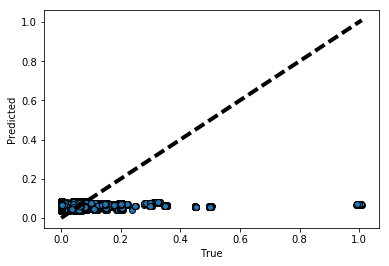

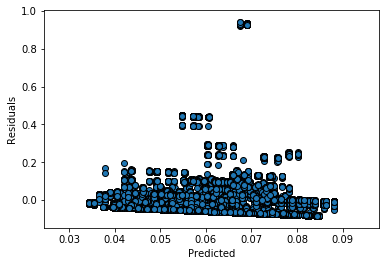

In [56]:
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import StandardScaler

kf = KFold(10)
k = 1
lr = linear_model.LinearRegression()
for train_index, test_index in kf.split(X_new_f): # Output 10 train test RMSE values
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr.fit(X_train, y_train)
    pred_train, pred_test = lr.predict(X_train), lr.predict(X_test)
    
    rmse_train, rmse_test = sqrt(mean_squared_error(y_train, pred_train)), sqrt(mean_squared_error(y_test, pred_test))
    print("Fold %i: train RMSE = %.3f, test RMSE = %.3f" % (k, rmse_train, rmse_test))
    k += 1

lr = linear_model.LinearRegression()
predicted = cross_val_predict(lr, X_new_f, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
plt.show()

fig, ax = plt.subplots()
residuals = y - predicted
ax.scatter(predicted, residuals, edgecolors=(0, 0, 0))
ax.set_xlabel('Predicted')
ax.set_ylabel('Residuals')
plt.show()



Using f regression, the model's performance is basically identical to those from (i) and (ii). This observation can be used as evidence to believe that the original linear model only weighs these three features to make the final prediction, essentially almost ignoring the other two features as they do not contribute as much.

Fold 1: train RMSE = 0.103, test RMSE = 0.107
Fold 2: train RMSE = 0.104, test RMSE = 0.100
Fold 3: train RMSE = 0.103, test RMSE = 0.107
Fold 4: train RMSE = 0.104, test RMSE = 0.100
Fold 5: train RMSE = 0.103, test RMSE = 0.107
Fold 6: train RMSE = 0.104, test RMSE = 0.100
Fold 7: train RMSE = 0.103, test RMSE = 0.107
Fold 8: train RMSE = 0.104, test RMSE = 0.100
Fold 9: train RMSE = 0.103, test RMSE = 0.107
Fold 10: train RMSE = 0.104, test RMSE = 0.100


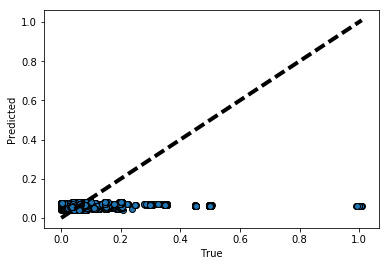

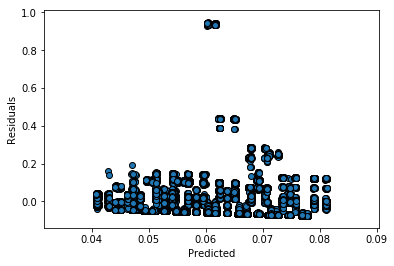

In [57]:
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import StandardScaler

kf = KFold(10)
k = 1
lr = linear_model.LinearRegression()
for train_index, test_index in kf.split(X_new_m): # Output 10 train test RMSE values
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr.fit(X_train, y_train)
    pred_train, pred_test = lr.predict(X_train), lr.predict(X_test)
    
    rmse_train, rmse_test = sqrt(mean_squared_error(y_train, pred_train)), sqrt(mean_squared_error(y_test, pred_test))
    print("Fold %i: train RMSE = %.3f, test RMSE = %.3f" % (k, rmse_train, rmse_test))
    k += 1

lr = linear_model.LinearRegression()
predicted = cross_val_predict(lr, X_new_m, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
plt.show()

fig, ax = plt.subplots()
residuals = y - predicted
ax.scatter(predicted, residuals, edgecolors=(0, 0, 0))
ax.set_xlabel('Predicted')
ax.set_ylabel('Residuals')
plt.show()



In the case of using mutual info regression, the two graphs above finally differs from the previous ones. The graphs indicate a decrease in regression performance as many residuals are now above 0, as there is no giant cluster of residuals ceneterd around 0.

iv) Here, we utilize 32 feature encodings that encapsulate all the feature combinations generated from 5 features (2^5 = 32). 